# Simulation functions

In [170]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from scipy.stats import ortho_group 

In [200]:
def get_sigma_hat(sigma, n=10000):
    """Generate observations and get sample covariance matrix"""
    X = np.random.multivariate_normal([0]*sigma.shape[0], sigma, n).T
    sigma_hat = np.cov(X)
    
    return sigma_hat

def get_eigen(mat):
    """Get the eigenvectors and eigenvalues in decreasing order of eigenvalues """
    eigenval, eigenvec = np.linalg.eigh(mat)
    eigenvec = eigenvec.T
    zipped = zip(eigenval,eigenvec)
    eigenvec = [x for _,x in sorted(zipped, key = lambda y : y[0], reverse = True)]  # Sorting vectors/values in decreasing order of values
    eigenval = sorted(eigenval, reverse = True)
    return np.array(eigenval), np.array(eigenvec)

def get_norm_mat(mat):   # Works for mat symmetric 
    """Get the norm of a symmetric matrix"""
    eigenval, eigenvec = get_eigen(mat)
    
    return max(np.abs(eigenval))

In [209]:
def get_spike_matrix(s, k=1, p=50):
    """Get a spiked covariance matrix given an input of coefficients """
    v = ortho_group.rvs(dim=p)[:,:k]
    res = np.identity(p) 
    for i in range(k):
        res += s[i]*np.dot(v[:,i].reshape(p,1),v[:,i].reshape(p,1).T)
    
    return res
    
def get_spike_eigen(s, k=1, p=50):
    """Same as get_spike_matrix but also outputs eigenvalues/eigenvectors"""
    b = ortho_group.rvs(dim=p)
    v = b[:,:k]
    res = np.identity(p) 
    for i in range(k):
        res += s[i]*np.dot(v[:,i].reshape(p,1),v[:,i].reshape(p,1).T)
    
    eigenvec = [list(b[:,j-1:j]) for j in range(1,p+1)]
    eigenval = [j+1 for j in s] + [1]*(p-len(s))
    zipped = zip(eigenval,eigenvec)
    eigenvec = [x for _,x in sorted(zipped, key = lambda y : y[0], reverse = True)]
    eigenval = sorted(eigenval, reverse = True)

    return res, np.array(eigenval), np.array(eigenvec).reshape((p,p)) 
    


In [212]:
def get_eigen_error(eigenval, eigenvec, eigenval_hat, eigenvec_hat):
    """Get the error between eigenvalues and eigenvectors"""
    vec_err = []
    val_err = []
    
    val_err = np.abs(eigenval - eigenval_hat)
    vec_err = np.minimum(np.linalg.norm(eigenvec_hat - eigenvec, axis = 1),np.linalg.norm(eigenvec_hat + eigenvec, axis = 1))   
    return vec_err, val_err

# Influence of the spike and gap 

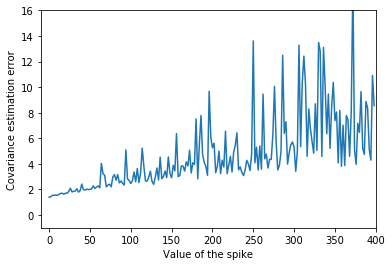

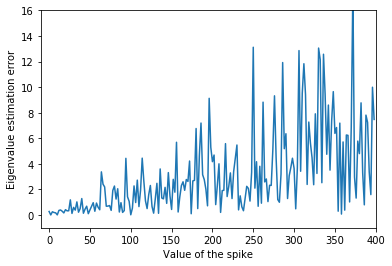

In [214]:
def plot_cov_eigenval_error(): 
    """Plots the covariance and eigenvalue estimation error for increasing spike"""
    
    spikes = [2*i for i in range(200)]
    mat_error = []
    eigenval_err = []
    
    for i in range(200):
        
        s = [spikes[i]]
        sigma, eigenval, eigenvec  = get_spike_eigen(s, p=100)
        
        sigma_hat = get_sigma_hat(sigma, n)
        eigenval_hat, eigenvec_hat = get_eigen(sigma_hat) 
        
        vec_err, val_err = get_eigen_error(eigenval, eigenvec, eigenval_hat, eigenvec_hat)
        
        eigenval_err.append(val_err[0])
        mat_error.append(np.linalg.norm(sigma - sigma_hat))
        
    plt.figure(0)
    plt.plot(spikes,mat_error)
    plt.xlabel('Value of the spike')
    plt.ylabel('Covariance estimation error')
    plt.axis([-10,400,-1,16])
    
    plt.figure(1)
    plt.plot(spikes, eigenval_err)
    plt.xlabel('Value of the spike')
    plt.ylabel('Eigenvalue estimation error')
    plt.axis([-10,400,-1,16])
    
    
        
plot_cov_eigenval_error()

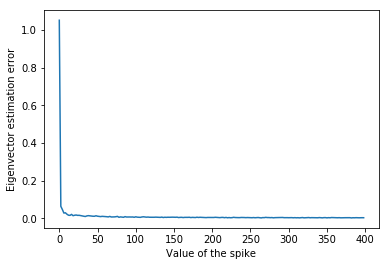

In [215]:
def plot_eigenvec_error(): 
    """Plot the eigenvector error with increasing spikes (for the first eigenvalue)"""
    spikes = [2*i for i in range(200)]
    eigenvec_err = []
    
    for i in range(200):
        
        s = [spikes[i]]
        
        sigma, eigenval, eigenvec  = get_spike_eigen(s, p=30)
        
        sigma_hat = get_sigma_hat(sigma, n)
        eigenval_hat, eigenvec_hat = get_eigen(sigma_hat) 
        
        vec_err, val_err = get_eigen_error(eigenval, eigenvec, eigenval_hat, eigenvec_hat)
        
        eigenvec_err.append(vec_err[0])
        
        
    plt.plot(spikes,eigenvec_err)
    plt.xlabel('Value of the spike')
    plt.ylabel('Eigenvector estimation error')
    #plt.axis([-20,400,-0.001,0.2])
    
    
        
plot_eigenvec_error()

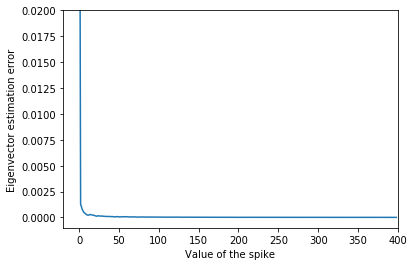

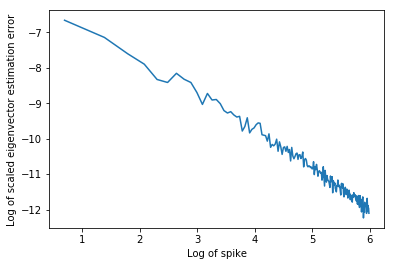

In [218]:
def plot_scaled_eigen_error(): 
    """Plot the scaled eigenvalue/eigenvector errors with increasing spikes (for the first eigenvalue)"""
    spikes = [2*i for i in range(200)]
    eigenvec_err = []
    
    for i in range(200):
        
        s = [spikes[i]]
        scale = np.sqrt((p+s[0])*(1+s[0]))
        
        sigma, eigenval, eigenvec  = get_spike_eigen(s, p=30)
        
        sigma_hat = get_sigma_hat(sigma, n)
        eigenval_hat, eigenvec_hat = get_eigen(sigma_hat) 
        
        vec_err, val_err = get_eigen_error(eigenval, eigenvec, eigenval_hat, eigenvec_hat)
        
        eigenvec_err.append(vec_err[0]/scale)
        
    plt.figure(0)    
    plt.plot(spikes,eigenvec_err)
    plt.xlabel('Value of the spike')
    plt.ylabel('Eigenvector estimation error')
    plt.axis([-20,400,-0.001,0.02])
        
    plt.figure(1)
    plt.plot(np.log(np.array(spikes[1:])),np.log(np.array(eigenvec_err[1:])))
    plt.xlabel('Log of spike')
    plt.ylabel('Log of scaled eigenvector estimation error')
    #plt.axis([-10,400,0,0.002])
    
   
    
    
        
plot_scaled_eigen_error()


# Constant norm and gap, effective rank increasing

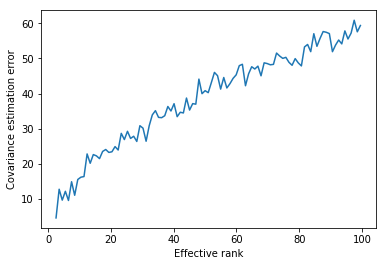

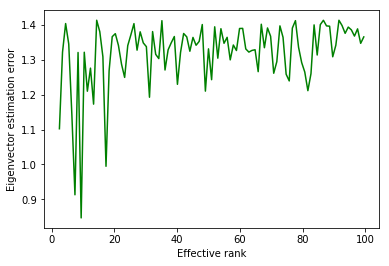

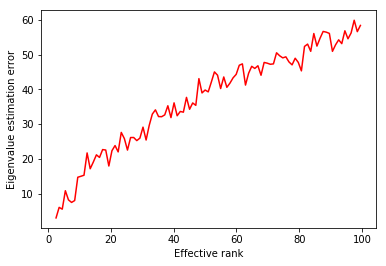

In [221]:
def plot_wrt_eff_rank(x): 
    """Plots covariance estimation error, eigenvalue/eigenvector estimation error with respect to the effective rank"""
    p = 100
    
    eigenvec_err = []
    eigenval_err = []
    mat_err = []
    
    eff_rank = [(x*(i+1) + p-i)/(x+1) for i in range(1,p)]
    s = [x]
    
    for i in range(1,p):
        s.append(x - 1)
        sigma, eigenval, eigenvec  = get_spike_eigen(s,len(s),p)
        
        sigma_hat = get_sigma_hat(sigma, n)
        eigenval_hat, eigenvec_hat = get_eigen(sigma_hat) 
        
        vec_err, val_err = get_eigen_error(eigenval, eigenvec, eigenval_hat, eigenvec_hat)
        
        mat_err.append(get_norm_mat(sigma_hat - sigma))
        eigenvec_err.append(vec_err[0])
        eigenval_err.append(val_err[0])
        
        
    plt.figure(0)
    plt.xlabel('Effective rank')
    plt.ylabel('Covariance estimation error')
    plt.plot(eff_rank,mat_err)
    #plt.plot(np.log(np.array(eff_rank)), np.log(np.array(vec_err)))
    
    plt.figure(1)
    plt.xlabel('Effective rank')
    plt.ylabel('Eigenvector estimation error')
    plt.plot(eff_rank,eigenvec_err, color = 'g')
    #plt.plot(np.log(np.array(eff_rank)), np.log(np.array(vec_err)))
    
    plt.figure(2)
    plt.xlabel('Effective rank')
    plt.ylabel('Eigenvalue estimation error')
    plt.plot(eff_rank,eigenval_err, color = 'r')
    #plt.plot(np.log(np.array(eff_rank)), np.log(np.array(val_err)))
   
    
        
plot_wrt_eff_rank(200)


# Consistency 

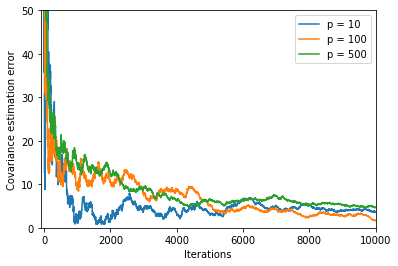

In [222]:
def consistency(n,p): 
    """Returns an array of covariance estimation errors with increasing sample length"""
    sigma = get_spike_matrix([200], 1, p)
    X = np.random.multivariate_normal([0]*p, sigma, n).T
    
    err = []
    sample_cov = np.zeros((p,p))
    
    for i in range(n):
        
        temp = np.dot(X[:,i].reshape(p,1),X[:,i].reshape(p,1).T)
        sample_cov = sample_cov + temp
        err.append(get_norm_mat((sample_cov/(i+1)) - sigma))
        
    return(err)


# Plotting the estimation error for different covariance matrix sizes
### Case n = 10000

p_space = [10,100,500]

plt.figure()

for p in p_space :
    
    err = consistency(10000,p)
    plt.plot(err, label = 'p = ' + str(p))
    

plt.axis([-100,10000,0,50])
plt.xlabel('Iterations')
plt.ylabel('Covariance estimation error')
plt.legend(loc = 'best')
plt.show()



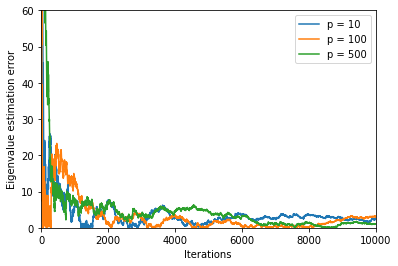

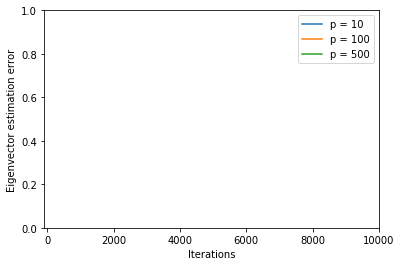

In [223]:
def consistency_eigen(n,p): 
    """Returns two arrays of eigenvalue/eigenvector estimation errors with increasing sample length"""
    
    sigma, eigenval, eigenvec = get_spike_eigen([200], 1, p)
    
    X = np.random.multivariate_normal([0]*p, sigma, n).T
    
    val_err = []
    vec_err = []
    sample_cov = np.zeros((p,p))
    
    for i in range(n):
        
        temp = np.dot(X[:,i].reshape(p,1),X[:,i].reshape(p,1).T)
        sample_cov = sample_cov + temp
        eigenval_hat, eigenvec_hat = get_eigen(sample_cov/(i+1))
        vec = eigenvec_hat[0].reshape((p,1))
        val_err.append(abs(eigenval_hat[0] - eigenval[0]))
        vec_err.append(min(np.linalg.norm(vec - eigenvec[0]),np.linalg.norm(vec + eigenvec[0])))
        
        
    return(val_err, vec_err)



p_space = [10,100,500]

val=[]
vec =[]
for p in p_space :
    val_err, vec_err = consistency_eigen(10000,p)
    val.append(val_err)
    vec.append(vec_err)

plt.figure(0)  
for i in range(3) :
    plt.plot(val[i], label = 'p = ' + str(p_space[i]))
    
plt.xlabel('Iterations')
plt.ylabel('Eigenvalue estimation error')
plt.legend(loc = 'best')
plt.axis([-10,10000,0,60])

plt.figure(1)  
for i in range(3):
    plt.plot(vec[i], label = 'p = ' + str(p_space[i]))
    
plt.xlabel('Iterations')
plt.ylabel('Eigenvector estimation error')
plt.legend(loc = 'best')
plt.axis([-100,10000,0,1])

plt.show()

In [ ]:
def plot_inconsistency(k):
    """Plots covariance estimation error with varying p"""
    n_space = np.vectorize(int)(np.linspace(100,5000,k))
    
    p_space = [int(n//3) for n in n_space]  # Varying p !
    p_test = 50   #Fixed p
    
    sigma_test = get_spike_matrix([100], 1, p_test)
    X_test = np.random.multivariate_normal([0]*p_test, sigma_test, n_space[-1]+1).T
    err_test = []
    
    err = []
    
    for i in range(k):
        
        #print(i)
        
        n = n_space[i]
        p = p_space[i]
        
        err_test.append(get_norm_mat(np.cov(X_test[:,:n])- sigma_test))
        
        sigma = get_spike_matrix([100], 1, p)
        X = np.random.multivariate_normal([0]*p, sigma, n).T
        err.append(get_norm_mat(np.cov(X) - sigma))
        
    return(err,err_test)
    
        
    
err, err_test = plot_inconsistency(40)
plt.plot(n_space, err, label = 'Varying p')
plt.plot(n_space, err_test, label = 'Fixed p')


plt.xlabel('Iterations')
plt.ylabel('Covariance estimation error')
plt.legend(loc = 'best')
plt.show()
    